# Cokriging from maximum likelihood estimates over continental US

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import fields
import cov_model
import cokrige
import krige_tools

In [4]:
# Analysis variables
timestamp = "2019-07-01"
timedelta = -1

In [30]:
# Get data: 5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_5deg_monthly_conus.nc")

# Format as multi-fields
timestamp = "2019-07-01"
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, standardize_window=True)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


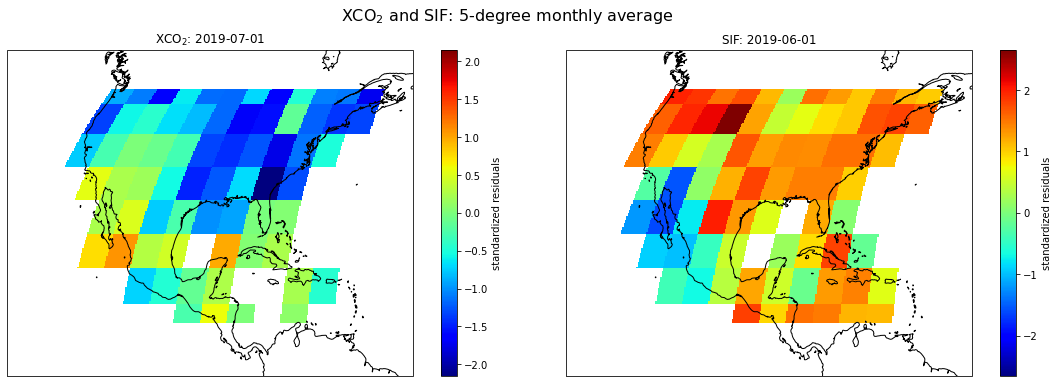

In [17]:
# Plot the data being used for cokriging
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(100, 100)
extents = [-125, -60, 5, 50]

fig.suptitle(
    "XCO$_2$ and SIF: 5-degree monthly average", 
    size=16, y=0.98
)

# Input data
ax1 = fig.add_subplot(gs[:, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:, 50:], projection=ccrs.EqualEarth())

xr.plot.imshow(
        darray=MF.field_1.to_xarray()["values"].T,
        transform=ccrs.PlateCarree(),
        ax=ax1,
        cmap="jet",
        cbar_kwargs={"label": "standardized residuals"},
    )
ax1.coastlines()
ax1.set_extent(extents)
ax1.set_title(f"XCO$_2$: {MF.field_1.timestamp}")

xr.plot.imshow(
        darray=MF.field_2.to_xarray()["values"].T,
        transform=ccrs.PlateCarree(),
        ax=ax2,
        cmap="jet",
        cbar_kwargs={"label": "standardized residuals"},
    )
ax2.coastlines()
ax2.set_extent(extents)
ax2.set_title(f"SIF: {MF.field_2.timestamp}");